In [107]:
#import
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


#load
X_train = np.loadtxt(open('samsung_HAR/samsung_train.txt', "rb"))
y_train = np.loadtxt(open('samsung_HAR/samsung_train_labels.txt', "rb"))
X_test = np.loadtxt(open('samsung_HAR/samsung_test.txt', "rb"))
y_test = np.loadtxt(open('samsung_HAR/samsung_test_labels.txt', "rb"))

# połącz wyniki 
X_merged = np.append(X_train, X_test, axis=0)
y_merged =np.append(y_train, y_test, axis=0)

# X = X_merged
# y = y_merged

X = X_train
y = y_train



# metoda zaporzyczona z przykładów sklearn oraz lekko zmodyfikowana zmodyfikowana 
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# metoda zaporzyczona z przykładów sklearn oraz lekko zmodyfikowana zmodyfikowana 
def plot_gaussian_mixture(clf, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clf.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=3, colors='b')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

    plt.xlabel("$x_1$", fontsize=14)
    plt.tick_params(labelleft=False)
    

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(klasyfikator, X):
    # wyznaczanie granic decyzyjnych, podobnie jak w poprzednich notatnikach
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # rysowanie konturów granic 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    
    # rysowanie danych
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # centra klastrów można wyciągnąc za pomocą zmiennej cluster_centers_
    plot_centroids(klasyfikator.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [108]:
# pipe1: preprocessing
pipe1 = Pipeline([
#     ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])
X_transformed = pipe1.fit_transform(X)   # fit_transform dla pipe
print(X_transformed[1])

[-5.53534954  0.08253025]


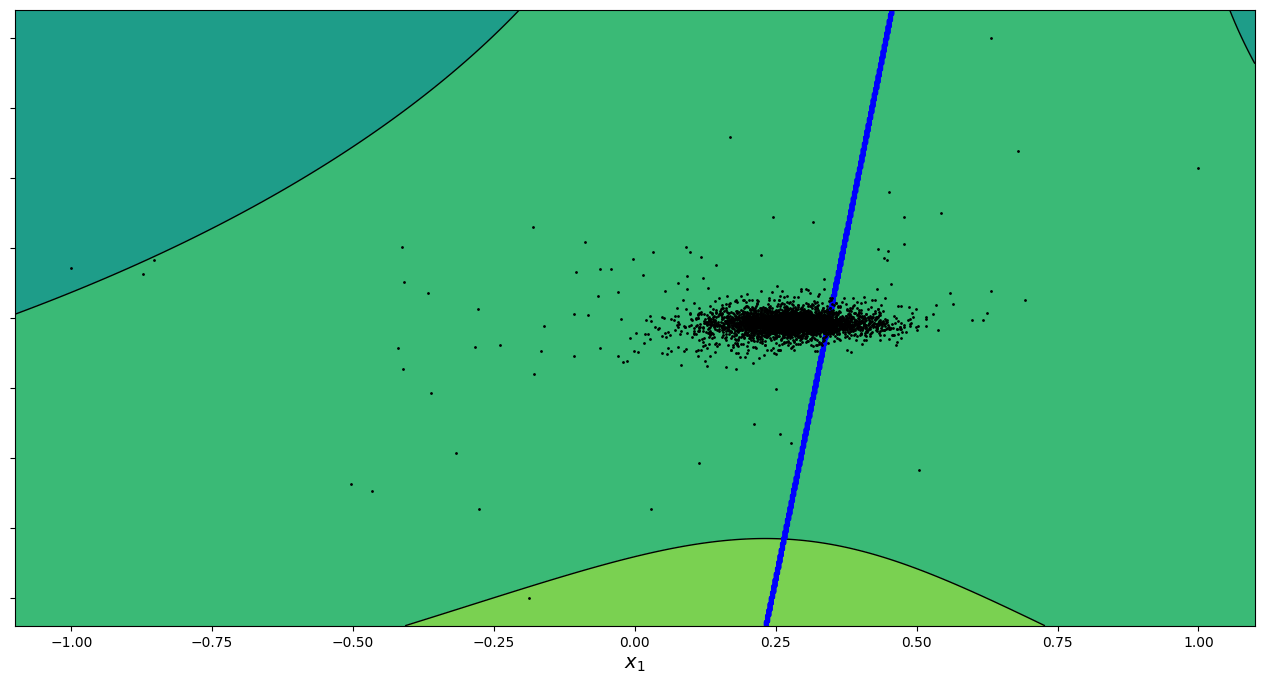

In [109]:
# pipe2: model only
pm_gm = Pipeline([
    ('model', GaussianMixture(n_components=6, n_init=10, random_state=42, covariance_type="diag"))
])

# Dane wejściowe
pm_gm.fit(X_transformed)

plt.figure(figsize=(16, 8))
plot_gaussian_mixture(pm_gm, X)
plt.show()


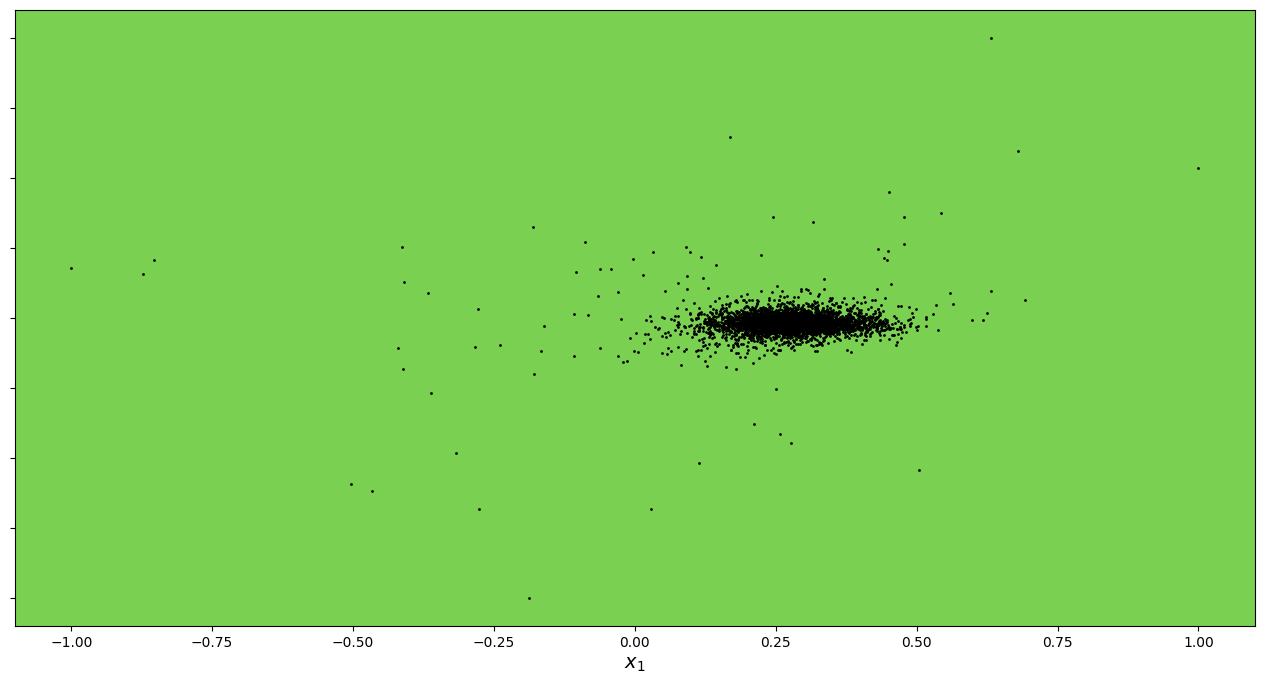

In [110]:
# wersja bez pipeline
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(X_scaler)

gm = GaussianMixture(n_components=6, n_init=10, random_state=42)
gm.fit(X_pca)

plt.figure(figsize=(16, 8))
plot_gaussian_mixture(gm, X)
plt.show()


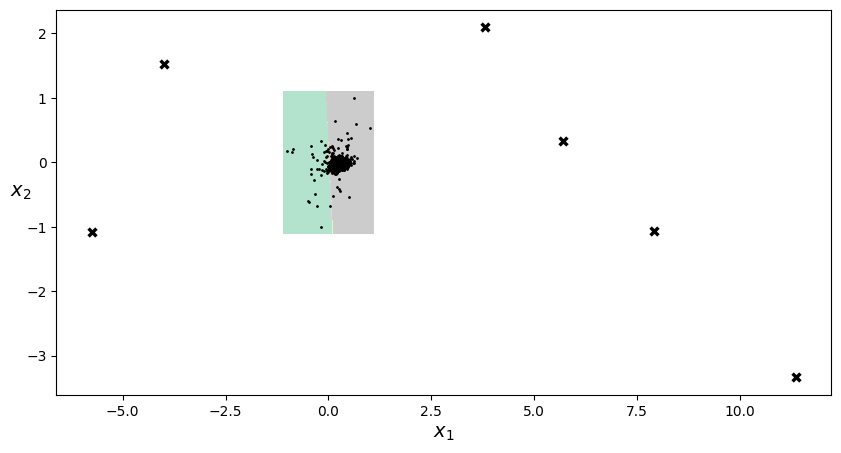

In [111]:
# # pipe2: model only
# pm_km = Pipeline([
#     ('model', KMeans(n_clusters=6))
# ])

pm_km = KMeans(n_clusters=6)
# Dane wejściowe
pm_km.fit(X_transformed)
pm_km.cluster_centers_

# y_pred = pm_km.fit_predict(X)
# print(y_pred)

plt.figure(figsize=(10, 5))
plot_decision_boundaries(pm_km, X)
plt.show()


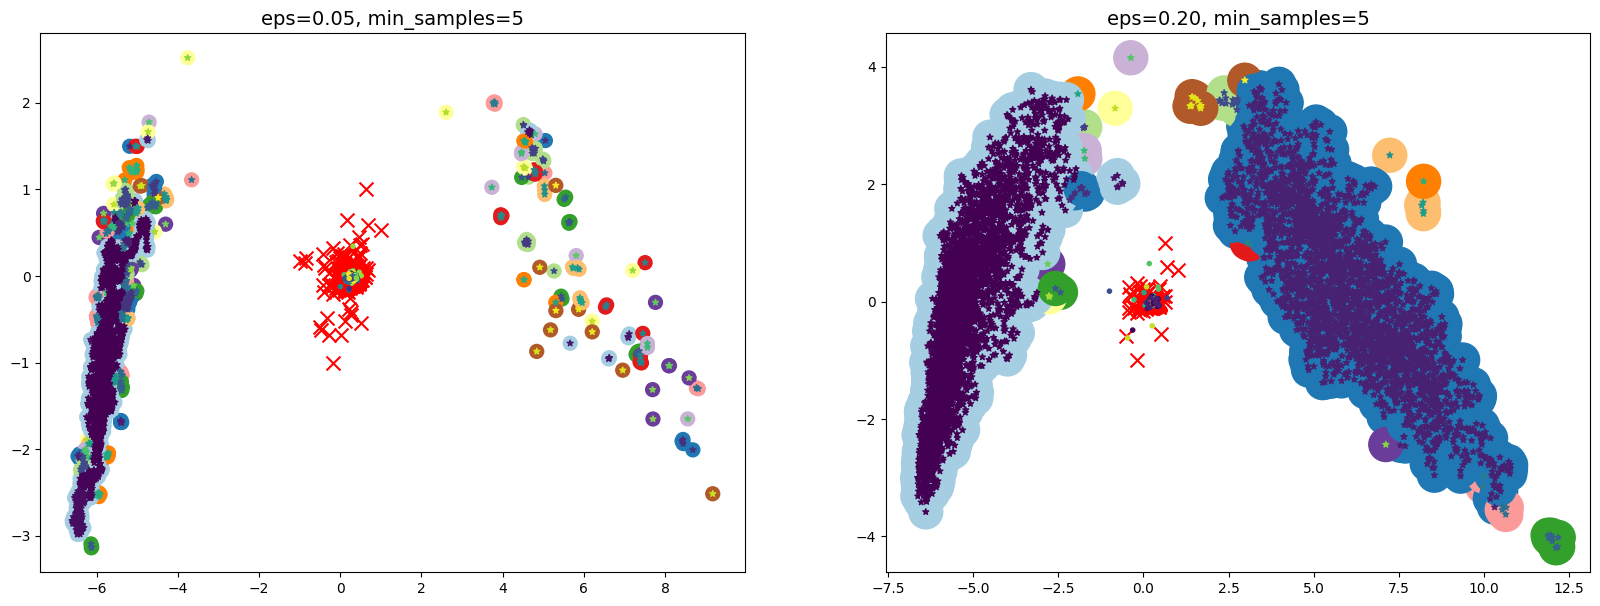

In [112]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
# tworzymy pierwszy klasyfikator DBSCAN z eps = 0.05
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X_transformed)

# drugi DBSCAN z eps = 0.2 (większy epsilon, większa przestrzeń wokół)
dbscan_2 = DBSCAN(eps=0.2, min_samples=5)
dbscan_2.fit(X_transformed)

plt.figure(figsize=(20, 7))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan_2, X, size=600)

plt.show()
